In [1]:
!rm -r /kaggle/working/*
%cd /kaggle/working

/kaggle/working


In [2]:
import os
import sys

PACKAGE_DIR = "/kaggle/src"
sys.path.append(PACKAGE_DIR)
sys.path.append(os.path.join(PACKAGE_DIR, "Penguin-ML-Library"))

In [3]:
import yaml
from penguinml.utils.logger import get_logger, init_logger
from penguinml.utils.set_seed import seed_base_torch

MODEL_NAME = "cnn"
CFG = yaml.safe_load(open(os.path.join(PACKAGE_DIR, "config.yaml"), "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])
CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

init_logger(f"{ CFG[MODEL_NAME]['execution']['exp_id']}.log")
logger = get_logger("main")
seed_base_torch(CFG[MODEL_NAME]["execution"]["seed"])

2024-11-15 22:40:32.674777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 22:40:32.703016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


exp_003


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
set seed: 46


In [4]:
import warnings

import numpy as np
import polars as pl
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [5]:
train = pl.read_csv(os.path.join(CFG["dataset"]["competition_dir"], "train_features.csv"))
train = (
    train.with_columns(
        pl.col("ID").str.split_exact("_", n=1).struct.rename_fields(["sceneID", "offset"]).alias("fields")
    )
    .unnest("fields")
    .with_columns(pl.col("offset").cast(pl.Float32))
)
print(train.shape)
train.head(1)

(43371, 32)


ID,vEgo,aEgo,steeringAngleDeg,steeringTorque,brake,brakePressed,gas,gasPressed,gearShifter,leftBlinker,rightBlinker,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5,sceneID,offset
str,f64,f64,f64,f64,f64,bool,f64,bool,str,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f32
"""00066be8e20318869c38c66be46663…",5.701526,1.538456,-2.165777,-139.0,0.0,false,0.25,true,"""drive""",false,false,2.82959,0.032226,0.045187,6.231999,0.065895,0.107974,9.785009,0.124972,0.203649,13.485472,0.163448,0.302818,17.574227,0.174289,0.406331,21.951269,0.199503,0.485079,"""00066be8e20318869c38c66be46663…",320.0


In [6]:
# normalize
META_COLS = [
    "vEgo",
    "aEgo",
    "steeringAngleDeg",
    "steeringTorque",
    "brakePressed",
    "gas",
    "gasPressed",
    "leftBlinker",
    "rightBlinker",
    "offset",
]

for col in META_COLS:
    train = train.with_columns((pl.col(col) - pl.col(col).mean()) / pl.col(col).std())

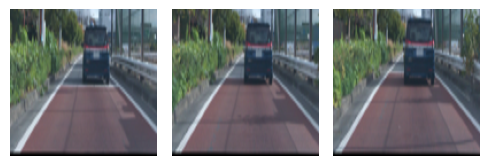

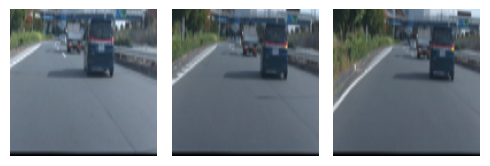

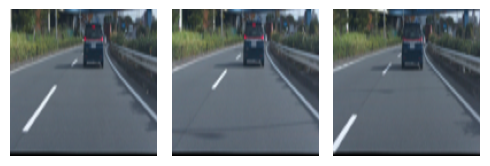

100%|██████████| 43371/43371 [01:41<00:00, 426.05it/s]


In [7]:
import os
import random
import sys
from typing import Dict

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import polars as pl
from PIL import Image
from torch.utils.data import Dataset

from const import TARGET_COLS

IMAGE_CACHE = {}

AUG_PROB = 0.5
IMG_SIZE = 128

train_aug = [
    # A.RandomBrightnessContrast(
    #     brightness_limit=(-0.2, 0.2),
    #     contrast_limit=(-0.2, 0.2),
    #     p=AUG_PROB,
    # ),
    # A.OneOf(
    #     [
    #         A.MotionBlur(blur_limit=5),
    #         A.MedianBlur(blur_limit=5),
    #         A.GaussianBlur(blur_limit=5),
    #         A.GaussNoise(var_limit=(5.0, 30.0)),
    #     ],
    #     p=AUG_PROB,
    # ),
    # A.OneOf(
    #     [
    #         A.OpticalDistortion(distort_limit=1.0),
    #         A.GridDistortion(num_steps=5, distort_limit=1.0),
    #         A.ElasticTransform(alpha=3),
    #     ],
    #     p=AUG_PROB,
    # ),
    # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE, IMG_SIZE),
    # A.CoarseDropout(
    #     max_holes=16,
    #     max_height=64,
    #     max_width=64,
    #     min_holes=1,
    #     min_height=4,
    #     min_width=4,
    #     p=AUG_PROB,
    # ),
    A.Normalize(mean=0.5, std=0.5),
]
valid_aug = [
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=0.5, std=0.5),
]


def load_image(ID: str) -> np.ndarray:
    if ID not in IMAGE_CACHE:
        image = np.concatenate(
            [
                cv2.cvtColor(
                    cv2.imread(os.path.join(CFG["dataset"]["competition_dir"], "images", ID, "image_t.png")),
                    cv2.COLOR_BGR2RGB,
                ),
                cv2.cvtColor(
                    cv2.imread(os.path.join(CFG["dataset"]["competition_dir"], "images", ID, "image_t-0.5.png")),
                    cv2.COLOR_BGR2RGB,
                ),
                cv2.cvtColor(
                    cv2.imread(os.path.join(CFG["dataset"]["competition_dir"], "images", ID, "image_t-1.0.png")),
                    cv2.COLOR_BGR2RGB,
                ),
            ],
            axis=2,
        )  # (H, W, C)
        IMAGE_CACHE[ID] = image
    return IMAGE_CACHE[ID].copy()


class Atma18ImageDataset(Dataset):
    def __init__(
        self,
        df: pl.DataFrame,
        aug,
    ):
        self.df = df
        self.aug = A.Compose(aug)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        ID = self.df["ID"][index]

        image = load_image(ID)
        image = self.aug(image=image)["image"]
        image = image.transpose(2, 0, 1)  # (H, W, C) -> (C, H, W)
        image = image.astype(np.float32)

        meta = self.df[META_COLS][index].to_numpy().flatten().astype(np.float32)

        targets = self.df[TARGET_COLS][index].to_numpy().flatten().astype(np.float32)

        return {"image": image, "meta": meta}, targets


# check
for i in range(3):
    dataset = Atma18ImageDataset(train, aug=train_aug)
    x, targets = dataset[i]
    image = x["image"]

    fig, axs = plt.subplots(1, 3, figsize=(5, 4))
    for j, ax in enumerate(axs):
        img = image[j * 3 : j * 3 + 3].transpose(1, 2, 0)
        img -= img.min()
        img /= img.max()
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# caching
for i in tqdm(range(len(train))):
    dataset[i]

In [8]:
import timm
import torch
from torch import nn


class Atma18CnnModel(nn.Module):
    def __init__(
        self,
        model_name="resnet18d",
        pretrained: bool = True,
        in_chans: int = 3,
        meta_dim: int = len(META_COLS),
        hidden_dim: int = 512,
        output_dim: int = 1,
        dropout: float = 0.0,
    ):
        super().__init__()

        self.backbone = timm.create_model(
            model_name=model_name,
            pretrained=pretrained,
            in_chans=in_chans,
            num_classes=0,
        )
        self.in_features = self.backbone.num_features

        self.meta_mlp = nn.Sequential(
            nn.Linear(meta_dim, meta_dim),
            # nn.ReLU(),
            # nn.Dropout(dropout),
            # nn.Linear(meta_dim, meta_dim),
            # nn.ReLU(),
            # nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.in_features + meta_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x) -> torch.Tensor:
        image, meta = x["image"], x["meta"]
        image = self.backbone(image)
        meta = self.meta_mlp(meta)
        x = torch.cat([image, meta], dim=1)
        x = self.head(x)
        return x

## CV Split


In [9]:
train_folds = pl.read_csv(CFG["dataset"]["train_fold_path"])
train = train.join(train_folds, on="sceneID", how="left")
assert train["fold"].null_count() == 0

## Training


In [10]:
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from penguinml.nn.utils.dataloader import get_dataloaders
from penguinml.nn.utils.trainer import Trainer
from torchmetrics import MeanAbsoluteError, MetricCollection
from transformers import get_cosine_schedule_with_warmup

In [11]:
oof_dfs = []
for fold in range(5):
    train_df = train.filter(pl.col("fold") != fold)
    valid_df = train.filter(pl.col("fold") == fold)

    train_dataset = Atma18ImageDataset(train_df, train_aug)
    valid_dataset = Atma18ImageDataset(valid_df, valid_aug)

    bs = 128

    train_dataloader, valid_dataloader = get_dataloaders(
        train_dataset,
        valid_dataset,
        batch_size=bs,
        num_workers=0,
        seed=CFG[MODEL_NAME]["execution"]["seed"],
    )

    device = "cuda"
    model = model = Atma18CnnModel(
        model_name="convnext_base_384_in22ft1k",
        pretrained=True,
        in_chans=9,
        hidden_dim=512,
        output_dim=len(TARGET_COLS),
    ).to(device)

    max_epoch = CFG[MODEL_NAME]["trainer"]["max_epoch"]
    loss_fn = nn.L1Loss()
    optimizer = optim.AdamW(model.parameters(), **CFG[MODEL_NAME]["optimizer"])
    num_training_steps = len(train_dataloader) * max_epoch
    scheduler = get_cosine_schedule_with_warmup(optimizer, 0, num_training_steps)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    metrics = MetricCollection([MeanAbsoluteError()])

    trainer = Trainer(
        model=model,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        metrics=metrics,
        save_path=f"best_model_fold{fold}.pth",
        **CFG[MODEL_NAME]["trainer"],
    )

    # train
    trainer.train()

    # val
    oof = trainer.inference()
    valid_df = valid_df.with_columns(*[pl.Series(TARGET_COLS[i], oof[:, i]) for i in range(len(TARGET_COLS))])
    oof_dfs.append(valid_df.select(["ID"] + TARGET_COLS))

    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()

== start training ==
train dataloader length: 272
valid dataloader length: 68
------------------------------
[epoch 0] train_MeanAbsoluteError: 1.665 train_loss: 1.663 valid_MeanAbsoluteError: 0.694 valid_loss: 0.6944
saved best model (inf -> 0.694)
[epoch 1] train_MeanAbsoluteError: 0.3633 train_loss: 0.3629 valid_MeanAbsoluteError: 0.2967 valid_loss: 0.2966
saved best model (0.694 -> 0.2967)
[epoch 2] train_MeanAbsoluteError: 0.2817 train_loss: 0.2817 valid_MeanAbsoluteError: 0.2646 valid_loss: 0.2646
saved best model (0.2967 -> 0.2646)
[epoch 3] train_MeanAbsoluteError: 0.2533 train_loss: 0.2534 valid_MeanAbsoluteError: 0.343 valid_loss: 0.3429
[epoch 4] train_MeanAbsoluteError: 0.2393 train_loss: 0.2391 valid_MeanAbsoluteError: 0.2632 valid_loss: 0.2631
saved best model (0.2646 -> 0.2632)
[epoch 5] train_MeanAbsoluteError: 0.2259 train_loss: 0.2259 valid_MeanAbsoluteError: 0.2508 valid_loss: 0.2507
saved best model (0.2632 -> 0.2508)
[epoch 6] train_MeanAbsoluteError: 0.2065 train_

In [13]:
oof_df = pl.concat(oof_dfs).sort("ID")
train = train.sort("ID")

mae = np.mean(np.abs(oof_df[TARGET_COLS].to_numpy() - train[TARGET_COLS].to_numpy()))
print(f"MAE: {mae}")

MAE: 0.283436442284283


In [14]:
oof_df = oof_df.rename({c: f"oof_{c}" for c in TARGET_COLS})
oof_df.write_csv(os.path.join(CFG["output_dir"], "oof.csv"))
oof_df.head(1)

ID,oof_x_0,oof_y_0,oof_z_0,oof_x_1,oof_y_1,oof_z_1,oof_x_2,oof_y_2,oof_z_2,oof_x_3,oof_y_3,oof_z_3,oof_x_4,oof_y_4,oof_z_4,oof_x_5,oof_y_5,oof_z_5
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""00066be8e20318869c38c66be46663…",2.654644,0.015564,-0.025126,5.915418,-0.03686,0.057765,9.506163,-0.081042,0.066433,13.431721,-0.103426,0.113282,17.530916,-0.18565,0.113507,21.735405,-0.173296,0.159599
